In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import ttest_1samp

import preprocessing

In [2]:
def ols(y, x):
    # ols regression
    # y = a + bx + e
    ## y : portfolio 수익률
    ## x : market 수익률
    ## e : 오차항(=0)

    x = sm.add_constant(x) # 상수항(a) 추가

    model = sm.OLS(y, x) # ols 모델 생성
    results = model.fit() # ols 모델 적합(a, b 추정)

    # results.params.values : (추정a, 추정b)
    hat_a, hat_b = results.params.values
    return (hat_a, hat_b), results

In [3]:
import scipy.stats as stats
from scipy.stats import wilcoxon

def test_aers(aers, alpha=0.05):
    # 표본의 크기 > 30
    print(f'검정 표본 크기 : {len(aers)}')
    
    # 정규성 검정 (Shapiro-Wilk test)
    stat, p_value = stats.shapiro(aers)

    print(f"정규성 검정: Statistic = {stat}, p-value = {np.round(p_value, 4)}")
    print(f'-> 정규성 만족 여부 : {p_value > 0.05}')

    # Wilcoxon Signed Rank Test 수행
    statistic, p_value = wilcoxon(aers - 0, alternative='greater')
    print(f"Wilcoxon Signed Rank 검정: Statistic = {statistic}, p-value = {np.round(p_value, 4)}")
    res_wilcoxon = p_value < 0.05
    print(f"-> 검정 결과 {'H0 기각, H1 채택(평균AER > 0)' if res_wilcoxon else 'H0 기각 불가'}")

    # 일표본 t-검정(단측검정)
    # H1 : mean(초과수익률) > 0 (pvalue < 0.05)
    result_ttest = ttest_1samp(aers, 0, alternative='greater')
    return result_ttest

In [4]:
def model_market(
        data,
        year_start = 2000,
        year_end = 2021,
        col_year = '귀속년도',
        col_rtn = 'rtn',
        col_event = 'event',
        val_event = 'santa',
        _print=True
    ):
    col_portfolio = col_rtn + '_portfolio'
    col_market = col_rtn + '_market'

    """ (1) 추정기간의 자료를 바탕으로 정상적인 기대수익률 모형 추정 """
    
    # 추정 기간의 자료
    data_before = data[data[col_event] != val_event]

    # 실제 수익률
    y = data_before[col_portfolio] # 포트폴리오 일 수익률
    x = data_before[col_market] # 시장 일 수익률

    # 알파, 베타 추정
    (hat_alpha, hat_beta), result_ols = ols(y, x)

    # 
    if _print:
        print("시장모형 추정 결과")
        print(result_ols.summary())
        print()


    """ (2) Event 기간의 자료를 바탕으로 정상적인 기대수익률 모형 값을 연결하여 초과수익률 계산 """
    
    # Event 기간의 자료
    data_event = data[data[col_event] == val_event]

    # 실제 수익률
    rtns_portfolio = data_event[col_portfolio] # 포트폴리오 일 수익률
    rtns_market = data_event[col_market] # 시장 일 수익률

    # 정상적 기대수익률 추정
    hat_portfolio = hat_alpha + hat_beta * rtns_market
    # hat_portfolio = result_ols.predict(rtns_market)

    data_event['hat_portfolio'] = hat_portfolio

    # 초과수익률(=비정상수익률) 계산 : 실제수익률 - 추정된 정상적 기대수익률
    aers = rtns_portfolio - hat_portfolio
    data_event['aers'] = aers

    # 
    if _print:
        print("연도별 초과수익률 평균")
        print(data_event[[col_year, 'aers']].groupby(col_year).mean())
        print()


    """ (3) 초과수익률의 유의성 검정 """
    result_test = test_aers(data_event['aers'])
    
    if _print:
        print("초과수익률 유의성 검정 (T-Test) 결과")
        print(result_test)
    if result_test.pvalue < 0.05:
        print(f"유의수준 0.05하에서 T-Test 검정 결과, pvalue={np.round(result_test.pvalue,4)}로 초과수익률이 유의함(초과수익률>0)")
    else:
        print("Event Study 결과, 초과수익률이 유의하지 않음")

    return data_event, (result_ols.summary(), result_test)

In [5]:
def study(
    symbol_portfolio, 
    symbol_market = '^KS11',
    col_rtn = 'rtn',
    col_event = 'event', 
    _print=False
):
    # 시장(KOSPI)의 일 수익률
    if _print:
        print(f"Market : {symbol_market}")
    data_market = preprocessing.get_data(symbol_market)[[col_rtn, col_event, '귀속년도']]

    # 포트폴리오의 일 수익률
    if _print:
        print(f"Portfolio : {symbol_portfolio}")
    data_portfolio = preprocessing.get_data(symbol_portfolio)[[col_rtn]]

    # 포트폴리오 날짜를 기준으로 병합
    data = pd.merge(
        data_portfolio, data_market,
        left_index=True, right_index=True,
        how='left',
        suffixes=('_portfolio', '_market')
    )

    # Event기간(data[col_event]=='santa')과 
    # 추정기간(data[col_event]=='before')의
    # 데이터만 남기기
    data = data[
        (data[col_event]=='santa') | (data[col_event] == 'before')
    ]
    data_event, results = model_market(data, _print=_print)

    return data, data_event, results

In [6]:
# KODEX 반도체
symbol = '091160.KS'

# # KOSDAQ
# symbol = '^KQ11'

# # 삼성전자
# symbol = '005930.KS'

data, data_event, results = study(symbol, _print=False)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
검정 표본 크기 : 105
정규성 검정: Statistic = 0.9945510029792786, p-value = 0.9541
-> 정규성 만족 여부 : True
Wilcoxon Signed Rank 검정: Statistic = 3962.0, p-value = 0.0001
-> 검정 결과 H0 기각, H1 채택(평균AER > 0)
유의수준 0.05하에서 T-Test 검정 결과, pvalue=0.0로 초과수익률이 유의함(초과수익률>0)


In [7]:
data_event

,rtn_portfolio,rtn_market,event,귀속년도,hat_portfolio,aers
Date,,,,,,
2009-12-23,-0.132890,0.350939,santa,2009.0,0.371089,-0.503980
2009-12-24,1.230863,1.263430,santa,2009.0,1.388146,-0.157283
2009-12-28,-1.051595,0.193183,santa,2009.0,0.195256,-1.246851
2009-12-29,0.498177,-0.777768,santa,2009.0,-0.886961,1.385138
2009-12-30,2.181093,0.615256,santa,2009.0,0.665696,1.515397
...,...,...,...,...,...,...
2023-12-26,-0.070087,0.118487,santa,2023.0,0.111999,-0.182086
2023-12-27,1.599102,0.419194,santa,2023.0,0.447166,1.151936
2023-12-28,0.165677,1.598624,santa,2023.0,1.761751,-1.596073


In [8]:
data_event['event'].value_counts()

event
santa    105
Name: count, dtype: int64

In [9]:
# data.groupby(['event', '귀속년도']).mean()

data.pivot_table(
    index='귀속년도',
    columns='event',
    aggfunc='mean'
)

rtn_market           rtn_portfolio          
event      before     santa        before     santa
귀속년도                                               
2009.0  -0.010503  0.302017      0.146620  0.731973
2010.0   0.202404  0.331651     -0.511540  0.812883
2011.0  -0.107575  0.221428     -0.647474  0.868229
2012.0   0.306142  0.144713     -0.260008  0.653652
2013.0   0.039336 -0.265704     -0.263468  0.204442
2014.0   0.199403 -0.200987      0.310940  0.616582
2015.0   0.322376 -0.446564      0.518468  0.021157
2016.0  -0.001616  0.058841      0.527395  0.535201
2017.0   0.084978  0.049608      0.255708  0.200996
2018.0   0.053729 -0.464439     -0.604298 -0.137667
2019.0   0.658029 -0.179554      1.403838  0.706616
2020.0  -0.186633  1.294418      0.037954  1.897476
2021.0   0.051830 -0.209664      0.641135 -0.057321
2022.0  -0.090349 -0.852986     -0.182613 -0.886915
2023.0   0.499183 -0.031902      0.578659  0.150103

In [10]:
data_event

,rtn_portfolio,rtn_market,event,귀속년도,hat_portfolio,aers
Date,,,,,,
2009-12-23,-0.132890,0.350939,santa,2009.0,0.371089,-0.503980
2009-12-24,1.230863,1.263430,santa,2009.0,1.388146,-0.157283
2009-12-28,-1.051595,0.193183,santa,2009.0,0.195256,-1.246851
2009-12-29,0.498177,-0.777768,santa,2009.0,-0.886961,1.385138
2009-12-30,2.181093,0.615256,santa,2009.0,0.665696,1.515397
...,...,...,...,...,...,...
2023-12-26,-0.070087,0.118487,santa,2023.0,0.111999,-0.182086
2023-12-27,1.599102,0.419194,santa,2023.0,0.447166,1.151936
2023-12-28,0.165677,1.598624,santa,2023.0,1.761751,-1.596073


In [11]:
data[data['event']=='santa']

,rtn_portfolio,rtn_market,event,귀속년도
Date,,,,
2009-12-23,-0.132890,0.350939,santa,2009.0
2009-12-24,1.230863,1.263430,santa,2009.0
2009-12-28,-1.051595,0.193183,santa,2009.0
2009-12-29,0.498177,-0.777768,santa,2009.0
2009-12-30,2.181093,0.615256,santa,2009.0
...,...,...,...,...
2023-12-26,-0.070087,0.118487,santa,2023.0
2023-12-27,1.599102,0.419194,santa,2023.0
2023-12-28,0.165677,1.598624,santa,2023.0


In [12]:
data_event.pivot_table(
    index='귀속년도',
    columns='event',
    aggfunc='mean'
)

,aers,hat_portfolio,rtn_market,rtn_portfolio
event,santa,santa,santa,santa
귀속년도,,,,
2009.0,0.415412,0.316561,0.302017,0.731973
2010.0,0.463292,0.349591,0.331651,0.812883
2011.0,0.641492,0.226737,0.221428,0.868229
2012.0,0.512421,0.141230,0.144713,0.653652
2013.0,0.520660,-0.316218,-0.265704,0.204442
2014.0,0.860666,-0.244084,-0.200987,0.616582
2015.0,0.538959,-0.517802,-0.446564,0.021157
2016.0,0.489683,0.045518,0.058841,0.535201


In [13]:
# ols 회귀적합결과
# const -> alpha, rtn_market -> beta
results[0] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          rtn_portfolio   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     93.70
Date:                Sat, 06 Jan 2024   Prob (F-statistic):           3.81e-16
Time:                        20:51:57   Log-Likelihood:                -148.91
No. Observations:                 105   AIC:                             301.8
Df Residuals:                     103   BIC:                             307.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0201      0.100     -0.201      0.841      -0.218       0.178
rtn_market     1.1146      0.115      9.680      0.000       0.886       1.343
==============================================================================
Omnibus:                        4.995   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                2.564
Skew:                           0.085   Prob(JB):                        0.278
Kurtosis:                       2.253   Cond. No.                         1.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# 초과수익률 유의성 검정 T-Test
results[1]

TtestResult(statistic=4.076587232784059, pvalue=4.4798432962037384e-05, df=104)

#### car 검정

In [15]:
# car : 이벤트 구간별 aer 누적합

cars = data_event.groupby('귀속년도')['aers'].sum()
cars

귀속년도
2009.0    2.907886
2010.0    3.243044
2011.0    4.490445
2012.0    3.586949
2013.0    3.644620
2014.0    6.024664
2015.0    3.772715
2016.0    3.427778
2017.0    1.160380
2018.0    2.800414
2019.0    6.487675
2020.0    3.323541
2021.0    1.375042
2022.0    0.587179
2023.0    1.440082
Name: aers, dtype: float64

In [16]:
len(cars) # < 30 이라 t검정 신뢰도 떨어짐

15

<Axes: xlabel='귀속년도'>

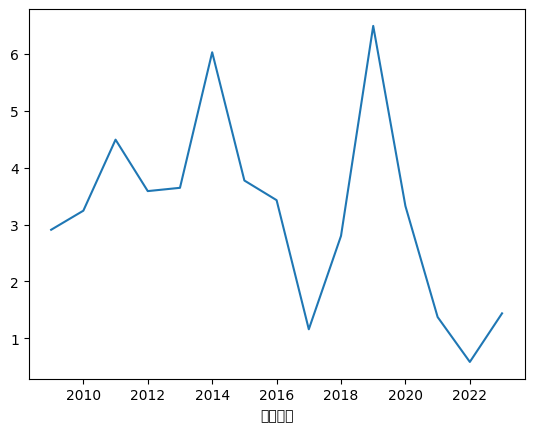

In [17]:
cars.plot()

In [18]:
import matplotlib.pyplot as plt
import platform
if platform.system() == 'Darwin': # MAC
    plt.rc('font', family='AppleGothic')
else: # Windows
    plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False


{'whiskers': [<matplotlib.lines.Line2D at 0x173d58140>,
 'caps': [<matplotlib.lines.Line2D at 0x173d58740>,
 'boxes': [<matplotlib.lines.Line2D at 0x1739cfe90>],
 'medians': [<matplotlib.lines.Line2D at 0x173d58d40>],
 'fliers': [<matplotlib.lines.Line2D at 0x173d59040>],
 'means': []}

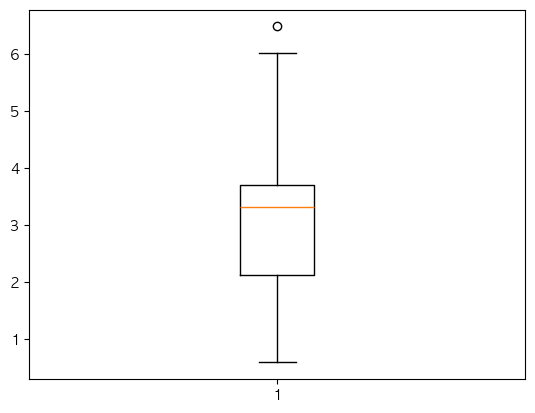

In [19]:
plt.boxplot(cars)

In [20]:
# mean(cars) != 0
# ttest_1samp(cars, 0).pvalue < 0.05

# mean(cars) > 0
ttest_1samp(cars, 0, alternative='greater').pvalue < 0.05

True

In [21]:
ttest_res = test_aers(cars)
ttest_res.pvalue < 0.05

검정 표본 크기 : 15
정규성 검정: Statistic = 0.9403477907180786, p-value = 0.3868
-> 정규성 만족 여부 : True
Wilcoxon Signed Rank 검정: Statistic = 120.0, p-value = 0.0
-> 검정 결과 H0 기각, H1 채택(평균AER > 0)


True